In [1]:
%matplotlib inline
import rebound
import numpy as np
import matplotlib.pyplot as plt
import reboundx
from reboundx import constants
import math
Mj = 955e-6 #...Jupiter mass in Solar units
import datetime
from mpl_toolkits.mplot3d import Axes3D




In [55]:
def setupSystem(e0=0.468600,a0=0.238900,mp=0.00202983,mstar=0.927):
    sim = rebound.Simulation()
    sim.add(m=mstar)
    sim.add(a=a0,e=e0,m=mp,inc=np.radians(35.614629))#,omega=np.radians(66.0054),Omega=0.,M=np.radians(0.698350))
    #sim.move_to_com() # Moves to the center of momentum frame
    #sim.move_to_hel()
    return sim


force_is_velocity_dependent = False
def orbitalEvolution(reb_sim,rebx_effect,dt,timing):
    #...Get parameters from simulation
    sim = reb_sim.contents
    msum = sim.particles[0].m + sim.particles[1].m
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz
    t = sim.t
    nyears = 2.*np.pi
    τ = 1.*nyears
    f = sim.particles[1].f
    Manom = sim.particles[1].M
    pomega = sim.particles[1].pomega
    n = sim.particles[1].n
    inc = sim.particles[1].inc
    node = sim.particles[1].Omega
    ω = sim.particles[1].omega
    e = sim.particles[1].e
    semi = sim.particles[1].a
    periq = semi*(1.0 - e)

    edotovere = (2.*np.pi*e0/τ)*np.cos(2.*np.pi*t/τ)/e
    adotovera = 0.0 #2.0*e**2.0*edotovere/(1.0 - e**2.0)
    idotoveri = 0.0
    if edotovere != 0.:
        if e == 0.:
            f = Manom
        else:
            temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2.0) - 1.0) /e
            temp = math.copysign(min(abs(temp),1.0),temp)
            f = math.acos(temp)
            if math.sin(Manom) < 0.:
                f = 2.*np.pi - f

        r = semi * (1.0-e**2.0)/(1.0+e*math.cos(f))
        rdot = math.sqrt(msum)*semi**(-1.0/2)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2)
        drdotde = rdot/(e*(1.0-e**2.0))
        rfdot = math.sqrt(msum)*semi**(-1.0/2)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2)
        drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))
        peri = (pomega - node + 2.*np.pi) % 2.*np.pi
        drde = -2.0*e*r/(1.0-e**2.0)-r**2.0*math.cos(f)/(semi*(1.0-e**2.0))

    ax =  -(vx+3.0*idotoveri*inc*z)/2.0*adotovera
    ay =  -(vy-3.0*idotoveri*inc*z)/2.0*adotovera
    az =  -(vz+3.0*idotoveri*inc*z)/2.0*adotovera
    vux = x*adotovera
    vuy = y*adotovera
    vuz = z*adotovera

    if edotovere != 0 and e < 1. and  e > 0:
        ax = ax + (math.cos(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f))- math.sin(node)*\
                 (drdotde*math.cos(inc)*math.sin(peri+f)+drfdotde*math.cos(inc)*math.cos(peri+f)-drde*z/r*idotoveri*inc))\
                 *edotovere*e
        ay = ay + (math.sin(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f))\
                 + math.cos(node)*(drdotde*math.cos(inc)*math.sin(peri+f)\
                 +drfdotde*math.cos(inc)*math.cos(peri+f)-drde*z/r*idotoveri*inc))*edotovere*e
        az = az + (drdotde*math.sin(inc)*math.sin(peri+f)+drfdotde*math.sin(inc)*math.cos(peri+f)\
                 +drde*math.cos(inc)*math.sin(peri+f)*idotoveri*inc)*edotovere*e
        vux = vux + (r/(semi*(1.0-e**2))-(1.0+e**2)/(1.0-e**2))*x*edotovere
        vuy = vuy + (r/(semi*(1.0-e**2))-(1.0+e**2)/(1.0-e**2))*y*edotovere
        vuz = vuz + (r/(semi*(1.0-e**2))-(1.0+e**2)/(1.0-e**2))*z*edotovere

    sim.particles[1].vx += vux
    sim.particles[1].vy += vuy
    sim.particles[1].vz += vuz
    sim.particles[1].ax += ax
    sim.particles[1].ay += ay
    sim.particles[1].az += az
    
    
#...Newtownian integration
year = 2.*np.pi # One year in units where G=1
def simIntegrate(sim,time_stop,Nout=100,addOrbitalEvolution=False):
    times = np.linspace(0.,time_stop*year,Nout)
    sim.integrator = "mercurius"
    e = np.zeros(Nout) 
    a = np.zeros(Nout)
    x = np.zeros(Nout)
    y = np.zeros(Nout)
    z = np.zeros(Nout)

    if addOrbitalEvolution == True: 
        rebx = reboundx.Extras(sim)
        custom_effect = rebx.add_custom_force(orbitalEvolution, force_is_velocity_dependent)
        
        for i,t in enumerate(times):
            sim.integrate(t)
            e[i] = sim.particles[1].e
            a[i] = sim.particles[1].a
            x[i] = sim.particles[1].x
            y[i] = sim.particles[1].y
            z[i] = sim.particles[1].z
            

            #print(i)
        times = times/(2.*np.pi)  
    return np.array([times,e,a,x,y,z])



In lines 68 through 75 in the cell above, the argument of certain sin and cos functions is `peri+f`, where `peri` is defined in line 57. In Wolff et al. (2012), the argument is `ω+f`, where `ω` is defined in line 34 by REBOUND as the argument of pericenter.
- Which argument should I use?
- If I choose `ω` should I also be applying the modulo operator?

In [52]:
def eEvol(e0,t,τ,evolType:str):
    if evolType == 'exp':
        e = e0*np.exp(-t/τ)
    elif evolType == 'trig':
        e = e0/const*(np.sin(2.*np.pi*t/τ) + 1)
    elif evolType == 'const':
        e = e0 * np.ones(len(t))
    return e

In [56]:
e0=0.5
nyears = 2.*np.pi
τ = 1.
t_stop = 10
sim = setupSystem(e0=e0)
data = simIntegrate(sim,t_stop,addOrbitalEvolution=True)
times,e,a,x,y,z = data


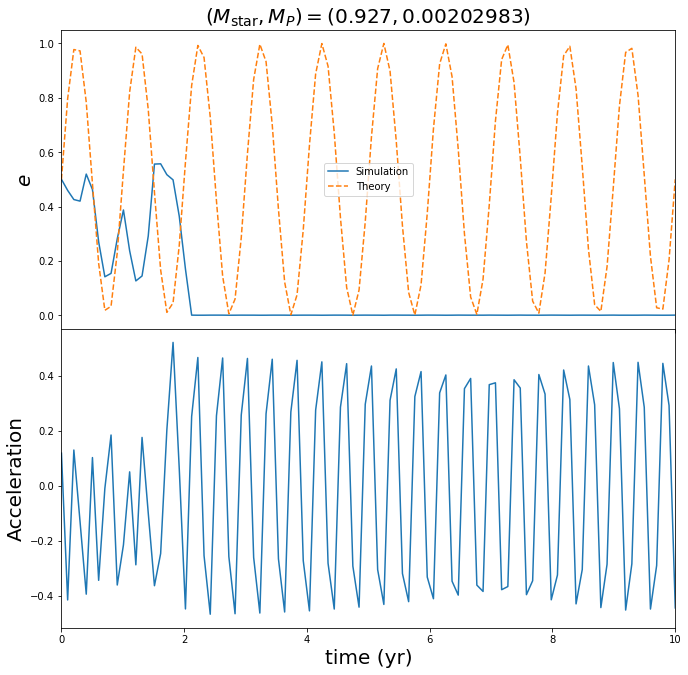

In [57]:
Mstar = sim.particles[0].m
Mp = sim.particles[1].m

e_theory = eEvol(e0,times,τ,'trig')
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True,figsize=(11,11)) 
plt.subplots_adjust(wspace=0, hspace=0)
ax = plt.gca() 
ax.autoscale(enable=True, axis='x', tight=True)

ax1.set_title(r'$(M_{\mathrm{star}},M_{P})=($'+str(Mstar)+'$,$'+str(Mp)+'$)$',fontsize=20)
ax1.plot(times,e,label='Simulation')
ax1.set_ylabel(r'$e$ ',fontsize=20)
ax1.plot(times,e_theory,'--',label='Theory')
#ax1.set_ylim(e0*0.9,e0*1.1)
#ax1.axhline(y=1,color='black')
#ax1.axvline(x=5,color='black')
ax1.legend()

ax2.plot(times,x)
#ax2.plot(times,y,label=r'$y$')
#ax2.plot(times,z,label=r'$z$')
ax2.set_ylabel('Acceleration',fontsize=20)
ax2.set_xlabel('time (yr)', fontsize=20)
plt.legend()

datestamp = str(datetime.datetime.now()).replace(" ","_")
savetag = 'orbitalEvolution_'
savetype = '.png'

#plt.savefig('plots/'+savetag+datestamp+savetype,dpi=300,bbox_inches='tight')

/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


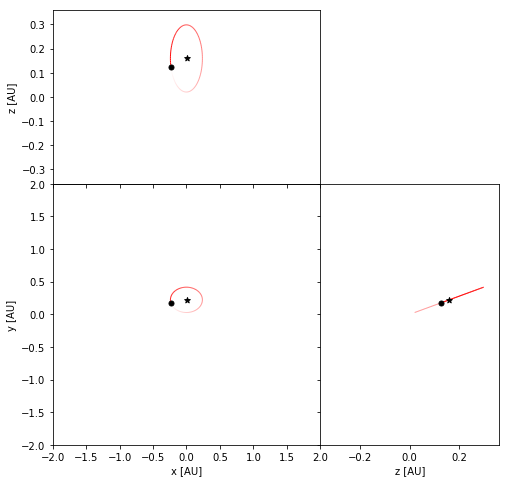

In [132]:
fig = rebound.OrbitPlot(sim,slices=True,color=True,unitlabel="[AU]",lim=2.,limz=0.36)